## Mask R-CNN for Pantograph Pose Estimation
---

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Add root to path 
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

# Import Mask RCNN
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.model import utils


tools = os.path.abspath("../../")
tools = tools+'/coco-master/PythonAPI'
if tools not in sys.path:
    sys.path.append(tools)
    
# for i in sys.path:
#     print(i)

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

# Import pantogrograph class
from dev import pantograph

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "models")

# Set path to root of images. 
DATA_DIR = os.path.join(ROOT_DIR, "datasets/pantograph")

print("Using Root dir:",ROOT_DIR)
print("Using Model dir:",MODEL_DIR)
print("Using Data dir:",DATA_DIR)

I've been imported
Using Root dir: /home/jupyter/GCP_Test
Using Model dir: /home/jupyter/GCP_Test/models
Using Data dir: /home/jupyter/GCP_Test/datasets/pantograph


Using TensorFlow backend.


In [2]:
import json
# Write json to file
def WriteJSON(obj,filename):
    try:
        with open(filename, 'w') as outfile:
#             obj_json = json.dumps(obj, sort_keys=True, indent=4,default=str)
            obj_json = json.dumps(obj, cls=NumpyArrayEncoder)
            outfile.write(obj_json)
    except Exception as e:
        print(e)
        print('File not written.')

# Read and return json object from file. If none, return empty object.
def ReadJSON(filename):
    try: 
        with open(filename) as f:
            obj = json.loads(f.read())
    except Exception as e: 
        obj = [] 
    return obj

In [3]:
# Compute Shortest path pixel distance between actual/pred
def ComputeEuclDistance(test_row,pred_row):
    return round(math.sqrt((test_row[0]-pred_row[0])**2+(test_row[1]-pred_row[1])**2), 2)
#     return round(math.sqrt((test_row['X']-pred_row['X'])**2+(test_row['Y']-pred_row['Y'])**2), 2)

# Compute absolute pixel distance between actual/pred
def ComputeABSDistance(test_row,pred_row):
    return abs(test_row['X']-pred_row['X'])+abs(test_row['Y']-pred_row['Y'])

In [4]:
def CreateTESTINGTable(image_id,keypoints,t_type):
    kp_names = ['L1','L2','L3','R3','R2','R1']

    cat_names = {
        0:'FB',
        1:'MB',
        2:'RB'
    }

    coll = []
    print('Incoming kp size:',keypoints.shape)
    for i in range(0,keypoints.shape[2]):
    #     print('i:',i)
        for j in range(0,keypoints.shape[1]):
    #         print('\t j:',j)
            x,y = list(keypoints[i][j])[:2]

            tmp = {
                'image_id':image_id,
                'class':cat_names[i],
                'kp_name':kp_names[j],
                'X':x,
                'Y':y,
                'type':t_type
            }
            coll.append(tmp)
            
    return coll

In [5]:
'''
Create Test and Prediction frames
'''
# REquires each anno to have 3 cats
def CreatePredTable(obj,image_ids):
    cat_names = {
            0:'FB',
            1:'MB',
            2:'RB'
        }

    pred_results = []
    hits = []
    # Loop through image_ids
    for image_id in image_ids:
        
        try:
        
            # Collect 3 sets of keypoints
            tmp = []
            found = 0
            # Loop through annotations. Stop if we find 3.
            for anno in obj['annotations']:
                # Match image_id and anno image_id
                if image_id == anno['image_id']:
                    found += 1
                    hit = anno['hit']
                    hits.append(hit)
                    kp = np.array(anno['keypoints'])
                    tmp.append(kp)
                if found > 2:
                    break
            # 
            stacked = np.stack(tmp) 
    #         print('Stacked kp shape',stacked.shape)

            pred_results += CreateTable(image_id,stacked,'pred')
        except Exception as e:
            print(e)
    #
    pred = CreateResultFrame(pred_results)
#     print('num hits',len(hits))
    
    shits = []
    for hit in hits:
        for i in range(1,7):
            shits.append(hit)
#     print('num hits',len(shits))
    pred['hit'] = shits
    
    return pred



def CreateTable(image_id,keypoints,t_type):
#     print('Incoming kp size:',keypoints.shape)
    kp_names = ['L1','L2','L3','R3','R2','R1']

    cat_names = {
        0:'FB',
        1:'MB',
        2:'RB'
    }

    coll = []
#     print(keypoints.shape[0])
    for i in range(0,keypoints.shape[0]):
    #     print('i:',i)
        for j in range(0,keypoints.shape[1]):
    #         print('\t j:',j)
            x,y,v = list(keypoints[i][j])[:] # use 2 for only x,y

            tmp = {
                'image_id':image_id,
                'class':cat_names[i],
                'kp_name':kp_names[j],
                'X':x,
                'Y':y,
                'V':v,
                'type':t_type
            }
            coll.append(tmp)
            
    return coll



def CreateResultTable(image_id,keypoints,r):
    kp_names = ['L1','L2','L3','R3','R2','R1']

    cat_names = {
        0:'FB',
        1:'MB',
        2:'RB'
    }

    coll = []
    for i in range(0,keypoints.shape[0]):
    #     print('i:',i)
        for j in range(0,keypoints.shape[1]):
    #         print('\t j:',j)
            x,y = list(keypoints[i][j])[:2]
            px,py = list(r['keypoints'][i][j])[:2]

            pixelDistance = ComputeEuclDistance(list(keypoints[i][j])[:2],list(r['keypoints'][i][j])[:2])

            tmp = {
                'image_id':image_id,
                'class':cat_names[i],
                'kp_name':kp_names[j],
                'Test_X':x,
                'Test_Y':y,
                'Pred_X':px,
                'Pred_Y':py,
                'PD':pixelDistance
            }
            coll.append(tmp)
            
    return coll


def CreateResultFrame(resultSet):
    df = pd.DataFrame(resultSet)
    cols = ['image_id','class','kp_name', 'X', 'Y','V','type']
    df = df[cols]
    
    return df

## Configurations

Run one of the code blocks below to import and load the configurations to use.

In [6]:
class InferenceConfig(pantograph.PantographConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

config.display()


Configurations Superlee:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        50
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0.5
IMAGE_PADDING                  True
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
KEYPOINT_MASK_POOL_SIZE        7
KEYPOINT_MASK_SHAPE            [56, 56]
KEYPOINT_THRESHOLD             0.005
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES        

## Load Dataset

In [7]:
# Load dataset
dataset = pantograph.PantographDataset()
dataset.load_pantograph(DATA_DIR, "val")#test

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))

for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Skeleton: (5, 2)
Keypoint names: (6,)
Image Count: 24
Class Count: 4
  0. BG                                                
  1. front_bar                                         
  2. middle_bar                                        
  3. rear_bar                                          


## Generate Dataframes

In [8]:
'''
Load image ids to match in dataset and pred file
'''

image_ids = dataset.image_ids.tolist()[:]
# image_ids = [0,2]
len(image_ids)

24

In [9]:
'''
Create Test DF
'''

gt_results = []
for image_id in image_ids:
    
    try:
    
        # Load annotations from file
        image, image_meta, class_ids, bbox, masks, keypoints =\
        modellib.load_image_gt_keypoints(dataset, config, 
                               image_id, augment=False,use_mini_mask=True)

        # Get single list 
        gt_results += CreateTable(image_id,keypoints,'test')
        
    except Exception as e:
        print(e)
    
test = CreateResultFrame(gt_results)
test

input type is not supported.


,image_id,class,kp_name,X,Y,V,type
0,0,FB,L1,217,649,2,test
1,0,FB,L2,307,603,2,test
2,0,FB,L3,325,599,2,test
3,0,FB,R3,733,599,2,test
4,0,FB,R2,751,603,2,test
...,...,...,...,...,...,...,...
409,23,RB,L2,321,625,2,test
410,23,RB,L3,370,613,1,test
411,23,RB,R3,709,603,1,test
412,23,RB,R2,751,610,2,test


In [10]:
'''
Create pred df
'''

PRED_FILE = DATA_DIR+'/val/pred_region_data.json'
obj = ReadJSON(PRED_FILE)

pred = CreatePredTable(obj,image_ids)
pred

need at least one array to stack


,image_id,class,kp_name,X,Y,V,type,hit
0,0,FB,L1,217,649,1,pred,True
1,0,FB,L2,305,606,1,pred,True
2,0,FB,L3,305,601,1,pred,True
3,0,FB,R3,703,597,1,pred,True
4,0,FB,R2,748,601,1,pred,True
...,...,...,...,...,...,...,...,...
409,23,RB,L2,343,623,1,pred,True
410,23,RB,L3,343,613,1,pred,True
411,23,RB,R3,696,603,1,pred,True
412,23,RB,R2,735,608,1,pred,True


In [ ]:
pred[pred['hit']==False]

In [11]:
'''
Merge test & pred. Compute PD for each KP.
'''

data = test.merge(pred,on=['image_id','class','kp_name'])

cols = ['image_id', 'class', 'kp_name', 'X_x', 'Y_x', 'V_x', 'type_x', 'X_y', 'Y_y', 'V_y',
       'type_y','hit']

newCols = ['image_id', 'class', 'kp_name', 'test_X', 'test_Y', 'test_V', 'type_x', 'pred_X', 'pred_Y', 'pred_V',
       'type_y','hit']

data = data.rename(columns=dict(zip(cols,newCols)))

cols = ['image_id', 'class', 'kp_name', 'test_X', 'test_Y', 'test_V',  'pred_X', 'pred_Y', 'pred_V','hit']
data = data[cols]

data.reset_index(drop=True)



data['PD'] = -1.0
rows = data.index.tolist()
for i in range(len(rows)):
    row = data.iloc[i]
    
    # Determine PD - Need to add use case for hit == False.
    pd = ComputeEuclDistance([row['test_X'],row['test_Y']],[row['pred_X'],row['pred_Y']])
    # Use vis to determine - 
    # test kp vis is 0(-1),
#     if row['test_X'] != -1 and row['test_Y'] != -1:
#         pd = ComputeEuclDistance([row['test_X'],row['test_Y']],[row['pred_X'],row['pred_Y']])
#     # pred kp vis is 0() 
#     elif row['pred_V'] == 0:
#         pass
#     else:
#         pd = -1
    
    # Set PD
    data.at[i,'PD'] = pd

# Keep only hits
misses = data[data['hit'] == False]

# Keep only hits
data = data[data['hit'] == True]



# Keep only kp vis match
offKeysA = data[(data['test_V'] == 0) & (data['pred_V'] == 1)].index.tolist()
offKeysB = data[(data['test_V'] == 1) & (data['pred_V'] == 0)].index.tolist()
keys = [i for i in data.index.tolist() if i not in offKeysA+offKeysB]


data = data.loc[keys].reset_index(drop=True)

# misses = [i for i in data.index.tolist() if i not in keys]
miss_data_index = offKeysA+offKeysB
tmp = data.loc[miss_data_index].reset_index(drop=True)

data

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:60: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


,image_id,class,kp_name,test_X,test_Y,test_V,pred_X,pred_Y,pred_V,hit,PD
0,0,FB,L1,217,649,2,217,649,1,True,0.00
1,0,FB,L2,307,603,2,305,606,1,True,3.61
2,0,FB,L3,325,599,2,305,601,1,True,20.10
3,0,FB,R3,733,599,2,703,597,1,True,30.07
4,0,FB,R2,751,603,2,748,601,1,True,3.61
...,...,...,...,...,...,...,...,...,...,...,...
322,23,RB,L2,321,625,2,343,623,1,True,22.09
323,23,RB,L3,370,613,1,343,613,1,True,27.00
324,23,RB,R3,709,603,1,696,603,1,True,13.00
325,23,RB,R2,751,610,2,735,608,1,True,16.12


In [12]:
misses

,image_id,class,kp_name,test_X,test_Y,test_V,pred_X,pred_Y,pred_V,hit,PD
60,3,MB,L1,191,670,2,269,656,1,False,79.25
61,3,MB,L2,285,594,2,346,616,1,False,64.85
62,3,MB,L3,342,591,2,346,606,1,False,15.52
63,3,MB,R3,745,579,2,693,596,1,False,54.71
64,3,MB,R2,802,580,2,731,601,1,False,74.04
...,...,...,...,...,...,...,...,...,...,...,...
313,18,MB,L2,247,594,2,299,551,1,False,67.48
314,18,MB,L3,325,579,2,341,546,1,False,36.67
315,18,MB,R3,719,570,2,684,529,1,False,53.91
316,18,MB,R2,786,576,2,726,534,1,False,73.24


In [14]:
misses.groupby(by=['image_id']).count()

,class,kp_name,test_X,test_Y,test_V,pred_X,pred_Y,pred_V,hit,PD
image_id,,,,,,,,,,
3,12,12,12,12,12,12,12,12,12,12
6,12,12,12,12,12,12,12,12,12,12
12,12,12,12,12,12,12,12,12,12,12
13,12,12,12,12,12,12,12,12,12,12
16,12,12,12,12,12,12,12,12,12,12
17,12,12,12,12,12,12,12,12,12,12
18,12,12,12,12,12,12,12,12,12,12


In [13]:
tmp

,image_id,class,kp_name,test_X,test_Y,test_V,pred_X,pred_Y,pred_V,hit,PD
0,2.0,MB,L2,256.0,718.0,2.0,263.0,719.0,1.0,True,7.07
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Keypoint Pixel Distance Evaluation

In [15]:
data.PD.describe()

count    327.000000
mean      18.379602
std       14.573489
min        0.000000
25%        6.320000
50%       16.000000
75%       24.135000
max       63.560000
Name: PD, dtype: float64

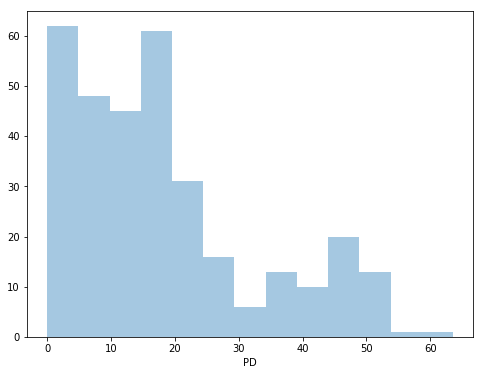

In [16]:
# Distribution of pixel distance for all classes
plt.figure(figsize=(8, 6))
sns.distplot(data["PD"],kde=False)

In [17]:
# PCT match by class

data['class'].value_counts()/test['class'].value_counts()

FB    0.782609
MB    0.673913
RB    0.913043
Name: class, dtype: float64

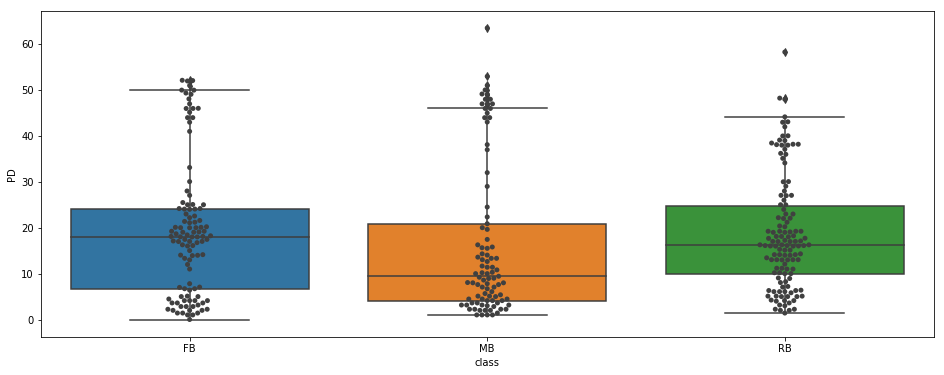

In [18]:
# Distribution of pixel distance by class

plt.figure(figsize=(16, 6))
ax = sns.boxplot(x="class", y="PD", data=data)
ax = sns.swarmplot(x="class", y="PD", data=data, color=".25")

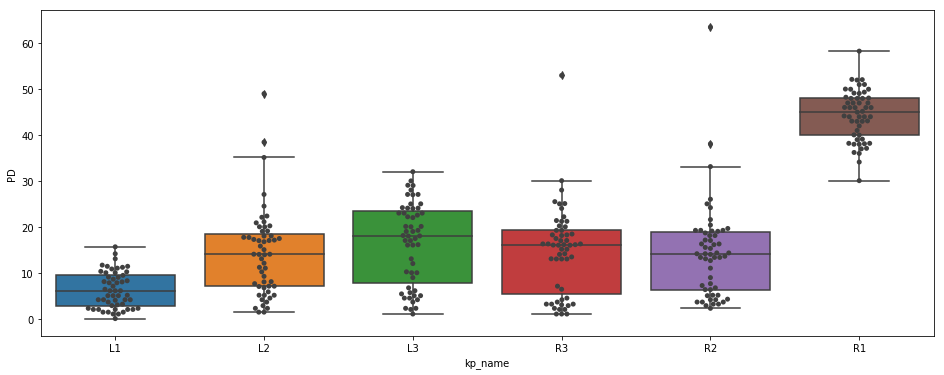

In [19]:
# Distribution of pixel distance by keypoint

plt.figure(figsize=(16, 6))
ax = sns.boxplot(x="kp_name", y="PD", data=data)
ax = sns.swarmplot(x="kp_name", y="PD", data=data, color=".25")

In [20]:
'''
PCT classifications under X pixel away from labeled position
'''

print("PD<= \t Count\t PCGT")
d = []
c = []
p = []
for i in [20,10,5,1]:
    d.append(i)
    c.append(data['PD'].map(lambda x: 1 if x<=i else 0).sum())
    p.append(data['PD'].map(lambda x: 1 if x<=i else 0).sum()/len(data)*100)
    print(i,'\t',data['PD'].map(lambda x: 1 if x<=i else 0).sum(),'\t',":",data['PD'].map(lambda x: 1 if x<=i else 0).sum()/len(data)*100)

PD<= 	 Count	 PCGT
20 	 218 	 : 66.66666666666666
10 	 114 	 : 34.862385321100916
5 	 68 	 : 20.795107033639145
1 	 7 	 : 2.1406727828746175


In [ ]:
grpd = data.groupby(by=['class','kp_name'])['PD'].mean().to_frame(name='mean').reset_index()
grpd

In [ ]:
data.head()

## Draw Keypoints

In [ ]:
'''
Draw labeled and predicted corner points
'''
from PIL import Image
def DrawCorners(data,imgPath,imgID):
#     print(path)

    colors = {
        'FB':'red',
        'MB':'green',
        'RB':'blue',
    }
    
    kp_names = ['L1','L2','L3','R3','R2','R1']

    cat_names = {
        0:'FB',
        1:'MB',
        2:'RB'
    }
    
    figsize = [24,24]
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
#     img = Image.open(imgPath)
    img, image_meta, class_ids, bbox, masks, keypoints =\
    modellib.load_image_gt_keypoints(dataset, config, 
                           imgID, augment=False,use_mini_mask=True)
    
    rows = data.index.tolist()
    for i in rows[:]:
        row = data.iloc[i]
        if row['image_id'] == imgID:
            
            test_circ = plt.Circle((row['test_X'], row['test_Y']), 3.0, facecolor=colors[row['class']]) # , edgecolor=colors[row['class']], color=colors[row['class']]
            ax.add_artist(test_circ)
           
            pred_circ = plt.Circle((row['pred_X'], row['pred_Y']), 3.0, facecolor=None, edgecolor=colors[row['class']],fill=False)
            ax.add_artist(pred_circ)
        

    ax.imshow(img)

In [ ]:
PRED_FILE = DATA_DIR+'/test/pred_region_data.json'
obj = ReadJSON(PRED_FILE)

t = 2
DrawCorners(data,obj['images'][t]['path'],obj['images'][t]['id'])

## COCO Evaluation

## Load Model

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
# Device to load the neural network on. Use CPU to leave GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference" # 'inference' or 'training'

In [ ]:
# Load model using selected device
with tf.device(DEVICE):
    
    # Recreate the model in inference mode
    model = modellib.MaskRCNN(mode="inference", 
                              config=config,
                              model_dir=MODEL_DIR)

    # Set local path to trained weights file
    LOG_DIR = os.path.join(MODEL_DIR, "pantograph20200324T2343")
    MODEL_PATH = os.path.join(LOG_DIR, "mask_rcnn_pantograph_0008.h5")


    # Load trained weights
    model.load_weights(MODEL_PATH, by_name=True)

In [ ]:
pantograph.evaluate_coco(model, dataset, pantograph, eval_type="bbox", limit=0, image_ids=[2])

In [ ]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(bbox, class_ids, masks,
                                          r['rois'], r['class_ids'], r['scores'],r['masks'])

visualize.plot_precision_recall(AP, precisions, recalls)